<a href="https://colab.research.google.com/github/2bahaa/Student-performance-Factor/blob/main/Student_score_performance_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
#imports needed

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


In [6]:
print("="*60)
print("Student Performance factor Model")
print("="*60)


try:
  df=pd.read_csv("/content/StudentPerformanceFactors.csv")
  print("Dataset Loaded Succesfully")
  print("dataset dimensions",df.shape)
except FileNotFoundError:
  print("Dataset file not found. Please ensure the CSV file is in the correct path.")
  print("Expected filename: 'student_performance_factors.csv'")
  print("Or update the file path in the code above.")
  exit()



Student Performance factor Model
Dataset Loaded Succesfully
dataset dimensions (6607, 20)


In [9]:
# Display basic information
print("\n" + "="*50)
print("DATASET OVERVIEW")
print("="*50)

print("\nColumn names and data types:")
print(df.dtypes)

print("\nFirst few rows:")
print(df.head())

print("\nDataset description:")
print(df.describe())

print("\nMissing values:")
print(df.isnull().sum())

# Check unique values for categorical columns
categorical_columns = ['Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities',
                      'Motivation_Level', 'Internet_Access', 'Tutoring_Sessions', 'Family_Income',
                      'Teacher_Quality', 'School_Type', 'Peer_Influence', 'Physical_Activity',
                      'Learning_Disabilities', 'Parental_Education_Level', 'Gender']

print("\nCategorical columns unique values:")
for col in categorical_columns:
    if col in df.columns:
        print(f"{col}: {df[col].unique()}")


DATASET OVERVIEW

Column names and data types:
Hours_Studied                  int64
Attendance                     int64
Parental_Involvement          object
Access_to_Resources           object
Extracurricular_Activities    object
Sleep_Hours                    int64
Previous_Scores                int64
Motivation_Level              object
Internet_Access               object
Tutoring_Sessions              int64
Family_Income                 object
Teacher_Quality               object
School_Type                   object
Peer_Influence                object
Physical_Activity              int64
Learning_Disabilities         object
Parental_Education_Level      object
Distance_from_Home            object
Gender                        object
Exam_Score                     int64
dtype: object

First few rows:
   Hours_Studied  Attendance Parental_Involvement Access_to_Resources  \
0             23          84                  Low                High   
1             19          64       

In [11]:
print("\n" + "="*50)
print("DATA CLEANING AND PREPROCESSING")
print("="*50)

# Make a copy for processing
df_clean = df.copy()

# Handle missing values
print("Handling missing values...")
for col in df_clean.columns:
    if df_clean[col].isnull().sum() > 0:
        if df_clean[col].dtype in ['int64', 'float64']:
            df_clean[col].fillna(df_clean[col].median(), inplace=True)
        else:
            df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)

print(f"Missing values after cleaning: {df_clean.isnull().sum().sum()}")



DATA CLEANING AND PREPROCESSING
Handling missing values...
Missing values after cleaning: 0


/tmp/ipython-input-11-2885649788.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)


In [12]:

# Encode categorical variables
print("\nEncoding categorical variables...")
label_encoders = {}

# Add 'Distance_from_Home' to the list of categorical columns to be encoded
categorical_columns = ['Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities',
                      'Motivation_Level', 'Internet_Access', 'Tutoring_Sessions', 'Family_Income',
                      'Teacher_Quality', 'School_Type', 'Peer_Influence', 'Physical_Activity',
                      'Learning_Disabilities', 'Parental_Education_Level', 'Gender', 'Distance_from_Home']


for col in categorical_columns:
    if col in df_clean.columns:
        le = LabelEncoder()
        df_clean[col + '_encoded'] = le.fit_transform(df_clean[col])
        label_encoders[col] = le
        print(f"✅ Encoded {col}")

# Remove outliers using IQR method for numerical columns
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers from key numerical columns
numerical_cols = ['Hours_Studied', 'Attendance', 'Sleep_Hours', 'Previous_Scores',
                 'Exam_Score']

original_size = len(df_clean)
for col in numerical_cols:
    if col in df_clean.columns:
        df_clean = remove_outliers_iqr(df_clean, col)

print(f"Removed {original_size - len(df_clean)} outliers")
print(f"Final dataset size: {len(df_clean)} samples")


Encoding categorical variables...
✅ Encoded Parental_Involvement
✅ Encoded Access_to_Resources
✅ Encoded Extracurricular_Activities
✅ Encoded Motivation_Level
✅ Encoded Internet_Access
✅ Encoded Tutoring_Sessions
✅ Encoded Family_Income
✅ Encoded Teacher_Quality
✅ Encoded School_Type
✅ Encoded Peer_Influence
✅ Encoded Physical_Activity
✅ Encoded Learning_Disabilities
✅ Encoded Parental_Education_Level
✅ Encoded Gender
✅ Encoded Distance_from_Home
Removed 134 outliers
Final dataset size: 6473 samples



DATA ANALYSIS: FEATURE CORRELATION WITH EXAM SCORE

Top features positively correlated with Exam_Score:
Attendance                   0.678945
Hours_Studied                0.494991
Previous_Scores              0.197971
Tutoring_Sessions_encoded    0.169800
Tutoring_Sessions            0.169800
Name: Exam_Score, dtype: float64

Top features negatively correlated with Exam_Score:
Family_Income_encoded           -0.017867
Teacher_Quality_encoded         -0.059073
Parental_Involvement_encoded    -0.092380
Learning_Disabilities_encoded   -0.102939
Access_to_Resources_encoded     -0.103482
Name: Exam_Score, dtype: float64


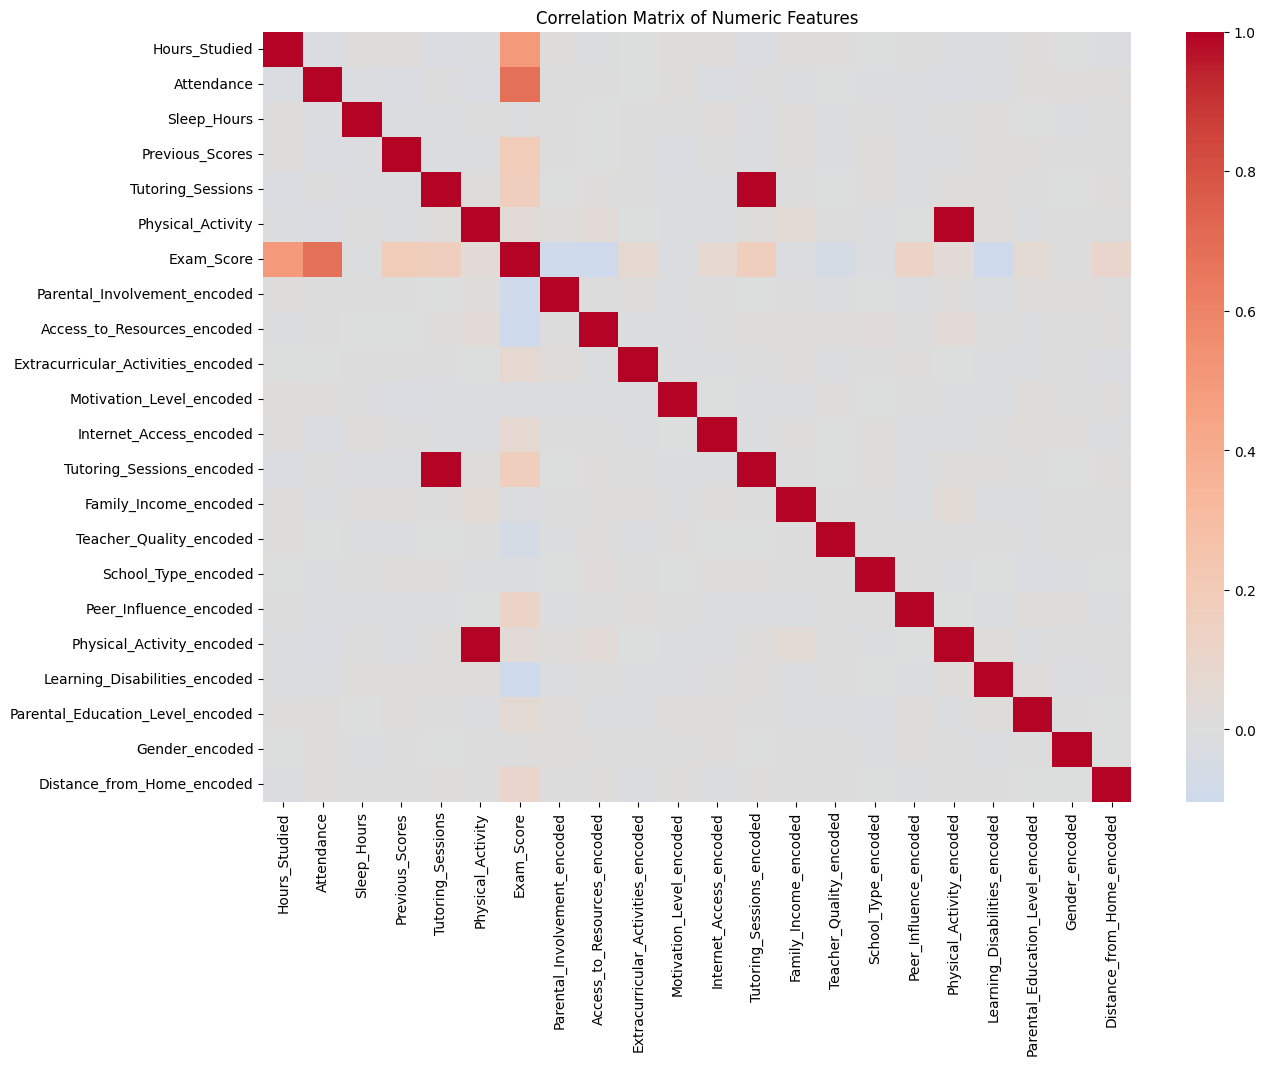

/tmp/ipython-input-13-1119119790.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=exam_corr[top_corr_features], y=top_corr_features, palette='viridis')


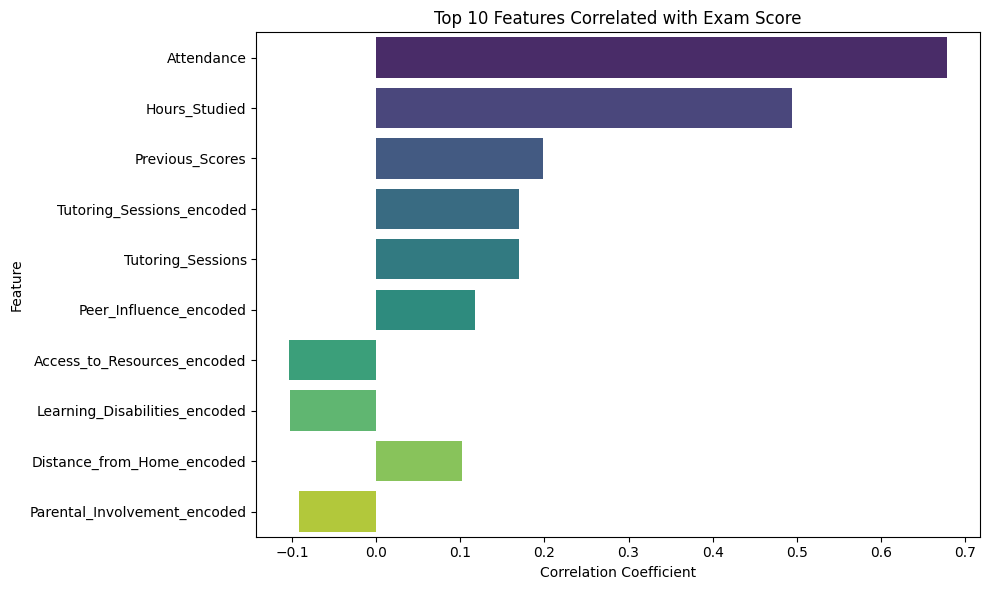

In [13]:
print("\n" + "="*50)
print("DATA ANALYSIS: FEATURE CORRELATION WITH EXAM SCORE")
print("="*50)

# Select only numeric columns (encoded + numerical)
numeric_features = df_clean.select_dtypes(include=[np.number])

# Compute correlation matrix
correlation_matrix = numeric_features.corr()

# Correlation with Exam_Score
exam_corr = correlation_matrix['Exam_Score'].sort_values(ascending=False)

print("\nTop features positively correlated with Exam_Score:")
print(exam_corr[1:6])  # Exclude the score itself at index 0

print("\nTop features negatively correlated with Exam_Score:")
print(exam_corr[-5:])

# Heatmap of correlation matrix
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
plt.title("Correlation Matrix of Numeric Features")
plt.show()

# Optional: Bar plot of top correlations
top_corr_features = exam_corr.drop('Exam_Score').abs().sort_values(ascending=False).head(10).index
plt.figure(figsize=(10, 6))
sns.barplot(x=exam_corr[top_corr_features], y=top_corr_features, palette='viridis')
plt.title("Top 10 Features Correlated with Exam Score")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [14]:
# ============================================================================
# STEP 4: FEATURE SELECTION AND PREPARATION
# ============================================================================

print("\n" + "="*50)
print("FEATURE SELECTION AND PREPARATION")
print("="*50)

# Define the top 3 selected features based on correlation
top_features = ['Attendance', 'Hours_Studied', 'Previous_Scores']

# Prepare feature matrix (X) and target vector (y)
X = df_clean[top_features]
y = df_clean['Exam_Score']

print(f"Selected features ({len(top_features)}): {top_features}")
print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")



FEATURE SELECTION AND PREPARATION
Selected features (3): ['Attendance', 'Hours_Studied', 'Previous_Scores']
Feature matrix shape: (6473, 3)
Target vector shape: (6473,)

Training set size: 5178
Test set size: 1295


In [15]:
# ============================================================================
# STEP 5: LINEAR REGRESSION MODEL
# ============================================================================

print("\n" + "="*50)
print("LINEAR REGRESSION MODEL")
print("="*50)

# Create and train the linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_test)

# Calculate metrics
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("Linear Regression Results:")
print(f"Mean Squared Error (MSE): {mse_lr:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_lr:.2f}")
print(f"Mean Absolute Error (MAE): {mae_lr:.2f}")
print(f"R² Score: {r2_lr:.4f}")



LINEAR REGRESSION MODEL
Linear Regression Results:
Mean Squared Error (MSE): 2.34
Root Mean Squared Error (RMSE): 1.53
Mean Absolute Error (MAE): 1.22
R² Score: 0.7741


In [16]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost Results:")
print("MSE:", mean_squared_error(y_test, y_pred_xgb))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print("MAE:", mean_absolute_error(y_test, y_pred_xgb))
print("R² Score:", r2_score(y_test, y_pred_xgb))


XGBoost Results:
MSE: 2.810427188873291
RMSE: 1.6764328763399061
MAE: 1.3285770416259766
R² Score: 0.7282983660697937


In [17]:
from xgboost import XGBRegressor
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd

# Assuming df_clean is already cleaned and encoded
# Define your target
y = df_clean['Exam_Score']

# Define all potential features
numerical_features = ['Hours_Studied', 'Attendance', 'Sleep_Hours', 'Previous_Scores']
encoded_features = [col for col in df_clean.columns if col.endswith('_encoded')]

all_features = numerical_features + encoded_features
X = df_clean[all_features]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("="*60)
print("PERFORMING FEATURE SELECTION WITH RFECV")
print("="*60)

# XGBoost base model
xgb_base = XGBRegressor(random_state=42, verbosity=0)

# RFECV for feature selection
rfecv = RFECV(estimator=xgb_base, step=1, scoring='r2', cv=5, n_jobs=-1)
rfecv.fit(X_train, y_train)

# Get best features
best_features = X_train.columns[rfecv.support_]
print(f"✅ Best features selected ({len(best_features)}): {list(best_features)}")

# Prepare reduced dataset
X_train_sel = X_train[best_features]
X_test_sel = X_test[best_features]

print("\n" + "="*60)
print("PERFORMING GRIDSEARCHCV ON XGBOOST")
print("="*60)

# Grid of hyperparameters to tune
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(XGBRegressor(random_state=42, verbosity=0),
                           param_grid,
                           cv=3,
                           scoring='r2',
                           n_jobs=-1,
                           verbose=1)

grid_search.fit(X_train_sel, y_train)

# Best model
best_model = grid_search.best_estimator_
print(f"✅ Best Params: {grid_search.best_params_}")

# Evaluate on test set
y_pred = best_model.predict(X_test_sel)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n" + "="*60)
print("XGBOOST RESULTS AFTER FEATURE SELECTION + GRID SEARCH")
print("="*60)
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.4f}")


PERFORMING FEATURE SELECTION WITH RFECV
✅ Best features selected (16): ['Hours_Studied', 'Attendance', 'Previous_Scores', 'Parental_Involvement_encoded', 'Access_to_Resources_encoded', 'Extracurricular_Activities_encoded', 'Motivation_Level_encoded', 'Internet_Access_encoded', 'Tutoring_Sessions_encoded', 'Family_Income_encoded', 'Teacher_Quality_encoded', 'Peer_Influence_encoded', 'Physical_Activity_encoded', 'Learning_Disabilities_encoded', 'Parental_Education_Level_encoded', 'Distance_from_Home_encoded']

PERFORMING GRIDSEARCHCV ON XGBOOST
Fitting 3 folds for each of 36 candidates, totalling 108 fits
✅ Best Params: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}

XGBOOST RESULTS AFTER FEATURE SELECTION + GRID SEARCH
Mean Squared Error (MSE): 0.21
Root Mean Squared Error (RMSE): 0.46
Mean Absolute Error (MAE): 0.36
R² Score: 0.9798


In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Define features and target
y = df_clean['Exam_Score']
numerical_features = ['Hours_Studied', 'Attendance', 'Sleep_Hours', 'Previous_Scores']
encoded_features = [col for col in df_clean.columns if col.endswith('_encoded')]
all_features = numerical_features + encoded_features
X = df_clean[all_features]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("="*60)
print("FEATURE SELECTION WITH LINEAR REGRESSION + RFECV")
print("="*60)

# Base Linear Regression model
lr = LinearRegression()

# RFECV for feature selection
rfecv = RFECV(estimator=lr, step=1, scoring='r2', cv=5, n_jobs=-1)
rfecv.fit(X_train, y_train)

# Selected features
selected_features = X_train.columns[rfecv.support_]
print(f"✅ Selected features ({len(selected_features)}): {list(selected_features)}")

# Prepare data with selected features
X_train_sel = X_train[selected_features]
X_test_sel = X_test[selected_features]

# Fit final Linear Regression model
final_model = LinearRegression()
final_model.fit(X_train_sel, y_train)

# Predict and evaluate
y_pred = final_model.predict(X_test_sel)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n" + "="*60)
print("LINEAR REGRESSION RESULTS AFTER FEATURE SELECTION")
print("="*60)
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.4f}")


FEATURE SELECTION WITH LINEAR REGRESSION + RFECV
✅ Selected features (18): ['Hours_Studied', 'Attendance', 'Previous_Scores', 'Parental_Involvement_encoded', 'Access_to_Resources_encoded', 'Extracurricular_Activities_encoded', 'Motivation_Level_encoded', 'Internet_Access_encoded', 'Tutoring_Sessions_encoded', 'Family_Income_encoded', 'Teacher_Quality_encoded', 'School_Type_encoded', 'Peer_Influence_encoded', 'Physical_Activity_encoded', 'Learning_Disabilities_encoded', 'Parental_Education_Level_encoded', 'Gender_encoded', 'Distance_from_Home_encoded']

LINEAR REGRESSION RESULTS AFTER FEATURE SELECTION
Mean Squared Error (MSE): 1.20
Root Mean Squared Error (RMSE): 1.09
Mean Absolute Error (MAE): 0.88
R² Score: 0.8841


In [19]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

# Step 1: Define features and target
y = df_clean['Exam_Score']

numerical_features = ['Hours_Studied', 'Attendance', 'Sleep_Hours', 'Previous_Scores']
encoded_features = [col for col in df_clean.columns if col.endswith('_encoded')]
all_features = numerical_features + encoded_features
X = df_clean[all_features]

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Generate polynomial features (degree=2)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
poly_feature_names = poly.get_feature_names_out(input_features=X_train.columns)

# Step 4: Apply RFECV to select best polynomial features
lr = LinearRegression()
rfecv = RFECV(estimator=lr, step=1, scoring='r2', cv=5, n_jobs=-1)
rfecv.fit(X_train_poly, y_train)

selected_features_mask = rfecv.support_
selected_feature_names = poly_feature_names[selected_features_mask]

print("="*60)
print("POLYNOMIAL REGRESSION FEATURE SELECTION (DEGREE 2)")
print("="*60)
print(f"✅ Selected polynomial features ({len(selected_feature_names)}):")
for feat in selected_feature_names:
    print(f" - {feat}")

# Step 5: Train final model on selected features
X_train_sel = X_train_poly[:, selected_features_mask]
X_test_sel = X_test_poly[:, selected_features_mask]

final_model = LinearRegression()
final_model.fit(X_train_sel, y_train)

# Step 6: Predict and evaluate
y_pred = final_model.predict(X_test_sel)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n" + "="*60)
print("POLYNOMIAL REGRESSION RESULTS")
print("="*60)
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.4f}")


POLYNOMIAL REGRESSION FEATURE SELECTION (DEGREE 2)
✅ Selected polynomial features (30):
 - Hours_Studied
 - Attendance
 - Previous_Scores
 - Parental_Involvement_encoded
 - Access_to_Resources_encoded
 - Extracurricular_Activities_encoded
 - Motivation_Level_encoded
 - Internet_Access_encoded
 - Tutoring_Sessions_encoded
 - Family_Income_encoded
 - Teacher_Quality_encoded
 - School_Type_encoded
 - Peer_Influence_encoded
 - Physical_Activity_encoded
 - Learning_Disabilities_encoded
 - Parental_Education_Level_encoded
 - Distance_from_Home_encoded
 - Parental_Involvement_encoded^2
 - Access_to_Resources_encoded^2
 - Extracurricular_Activities_encoded^2
 - Motivation_Level_encoded^2
 - Internet_Access_encoded^2
 - Internet_Access_encoded School_Type_encoded
 - Internet_Access_encoded Learning_Disabilities_encoded
 - Internet_Access_encoded Parental_Education_Level_encoded
 - Family_Income_encoded^2
 - Teacher_Quality_encoded^2
 - Learning_Disabilities_encoded^2
 - Learning_Disabilities_en

In [20]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

# ========== STEP 1: Load Data ==========
y = df_clean['Exam_Score']

# Shared train-test split for fair comparison
X_all = df_clean.drop(columns=['Exam_Score'])
X_train_full, X_test_full, y_train, y_test = train_test_split(X_all, y, test_size=0.2, random_state=42)

# ========== STEP 2: Define Features for Each Model ==========

features_xgb = [
    'Hours_Studied', 'Attendance', 'Previous_Scores', 'Parental_Involvement_encoded',
    'Access_to_Resources_encoded', 'Extracurricular_Activities_encoded', 'Motivation_Level_encoded',
    'Internet_Access_encoded', 'Tutoring_Sessions_encoded', 'Family_Income_encoded', 'Teacher_Quality_encoded',
    'Peer_Influence_encoded', 'Physical_Activity_encoded', 'Learning_Disabilities_encoded',
    'Parental_Education_Level_encoded', 'Distance_from_Home_encoded'
]

features_lr = [
    'Hours_Studied', 'Attendance', 'Previous_Scores', 'Parental_Involvement_encoded',
    'Access_to_Resources_encoded', 'Extracurricular_Activities_encoded', 'Motivation_Level_encoded',
    'Internet_Access_encoded', 'Tutoring_Sessions_encoded', 'Family_Income_encoded', 'Teacher_Quality_encoded',
    'School_Type_encoded', 'Peer_Influence_encoded', 'Physical_Activity_encoded', 'Learning_Disabilities_encoded',
    'Parental_Education_Level_encoded', 'Gender_encoded', 'Distance_from_Home_encoded'
]

# Same as in your polynomial regression results
features_poly = [
    'Hours_Studied', 'Attendance', 'Previous_Scores', 'Parental_Involvement_encoded',
    'Access_to_Resources_encoded', 'Extracurricular_Activities_encoded', 'Motivation_Level_encoded',
    'Internet_Access_encoded', 'Tutoring_Sessions_encoded', 'Family_Income_encoded', 'Teacher_Quality_encoded',
    'School_Type_encoded', 'Peer_Influence_encoded', 'Physical_Activity_encoded', 'Learning_Disabilities_encoded',
    'Parental_Education_Level_encoded', 'Distance_from_Home_encoded'
]

# ========== STEP 3: Train and Evaluate Models ==========

def evaluate_model(name, model, X_test, y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n{'='*60}\n{name.upper()} MODEL RESULTS\n{'='*60}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"R² Score: {r2:.4f}")

    return {
        'Model': name,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }

# ---------- XGBoost ----------
xgb = XGBRegressor(learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.8, random_state=42)
xgb.fit(X_train_full[features_xgb], y_train)
y_pred_xgb = xgb.predict(X_test_full[features_xgb])
results_xgb = evaluate_model("XGBoost", xgb, X_test_full[features_xgb], y_test, y_pred_xgb)

# ---------- Linear Regression ----------
lr = LinearRegression()
lr.fit(X_train_full[features_lr], y_train)
y_pred_lr = lr.predict(X_test_full[features_lr])
results_lr = evaluate_model("Linear Regression", lr, X_test_full[features_lr], y_test, y_pred_lr)

# ---------- Polynomial Regression ----------
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_full[features_poly])
X_test_poly = poly.transform(X_test_full[features_poly])

# You may have selected 30 polynomial terms — here we just use all transformed terms
poly_lr = LinearRegression()
poly_lr.fit(X_train_poly, y_train)
y_pred_poly = poly_lr.predict(X_test_poly)
results_poly = evaluate_model("Polynomial Regression", poly_lr, X_test_poly, y_test, y_pred_poly)

# ========== STEP 4: Display Results Summary ==========

summary = pd.DataFrame([results_xgb, results_lr, results_poly])
print("\n" + "="*60)
print("COMPARISON SUMMARY")
print("="*60)
print(summary.sort_values(by='R2', ascending=False).to_string(index=False))



XGBOOST MODEL RESULTS
Mean Squared Error (MSE): 0.21
Root Mean Squared Error (RMSE): 0.46
Mean Absolute Error (MAE): 0.36
R² Score: 0.9798

LINEAR REGRESSION MODEL RESULTS
Mean Squared Error (MSE): 1.20
Root Mean Squared Error (RMSE): 1.09
Mean Absolute Error (MAE): 0.88
R² Score: 0.8841

POLYNOMIAL REGRESSION MODEL RESULTS
Mean Squared Error (MSE): 0.11
Root Mean Squared Error (RMSE): 0.33
Mean Absolute Error (MAE): 0.28
R² Score: 0.9895

COMPARISON SUMMARY
                Model      MSE     RMSE      MAE       R2
Polynomial Regression 0.108456 0.329327 0.276148 0.989515
              XGBoost 0.209176 0.457358 0.364102 0.979778
    Linear Regression 1.198636 1.094822 0.882206 0.884120


/tmp/ipython-input-21-1296736969.py:26: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


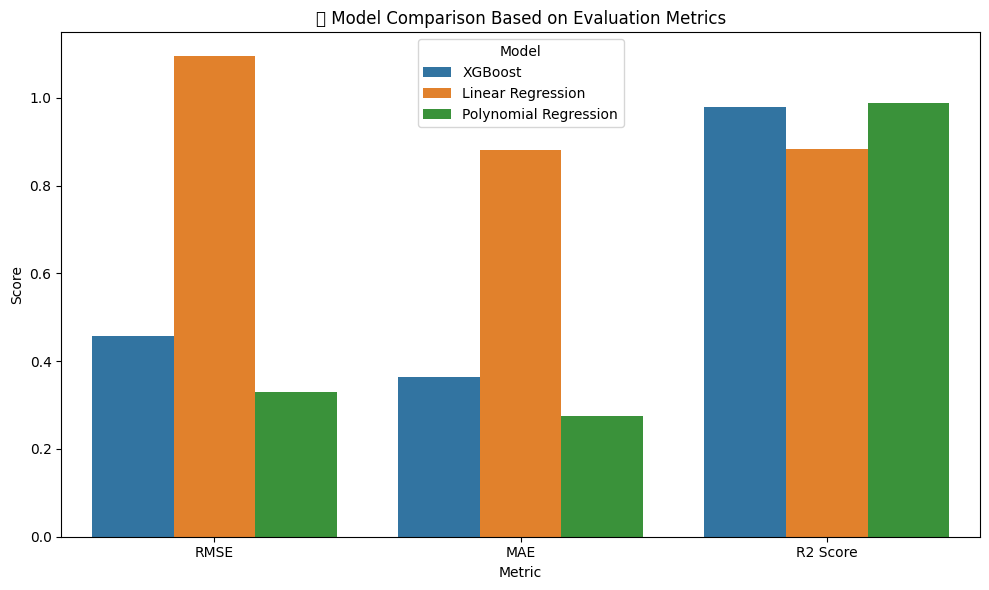

/tmp/ipython-input-21-1296736969.py:41: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


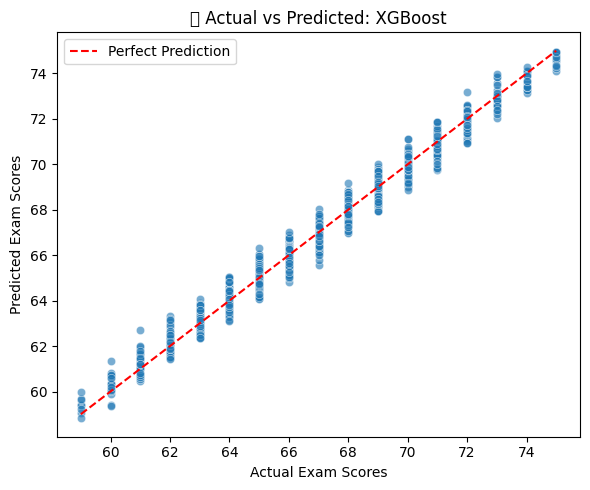

/tmp/ipython-input-21-1296736969.py:41: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


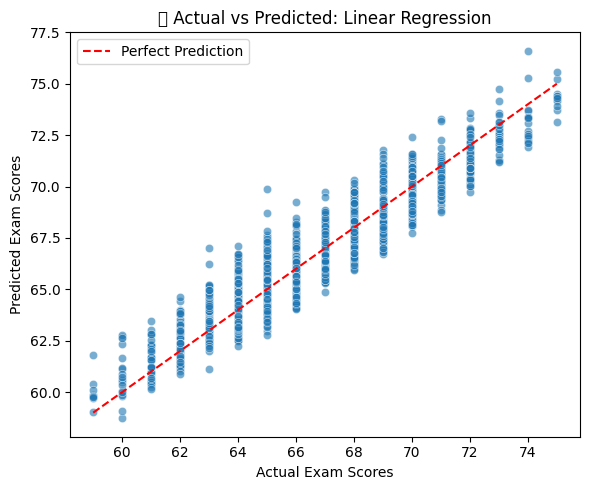

/tmp/ipython-input-21-1296736969.py:41: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


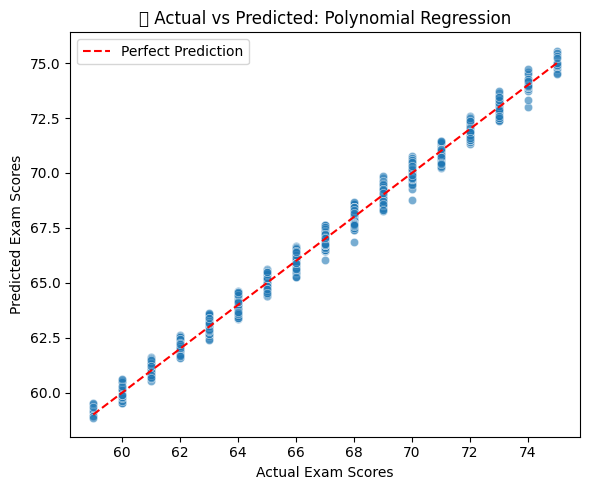

/tmp/ipython-input-21-1296736969.py:58: UserWarning: Glyph 127744 (\N{CYCLONE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127744 (\N{CYCLONE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


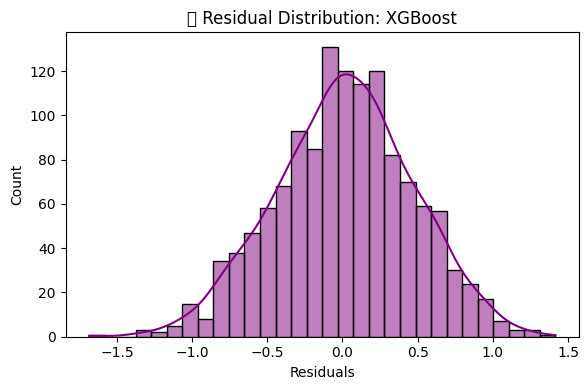

/tmp/ipython-input-21-1296736969.py:58: UserWarning: Glyph 127744 (\N{CYCLONE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127744 (\N{CYCLONE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


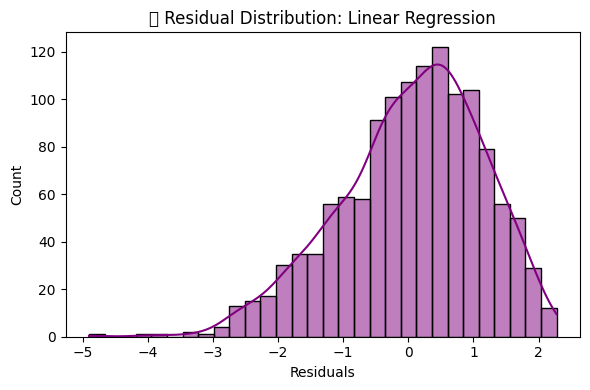

/tmp/ipython-input-21-1296736969.py:58: UserWarning: Glyph 127744 (\N{CYCLONE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127744 (\N{CYCLONE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


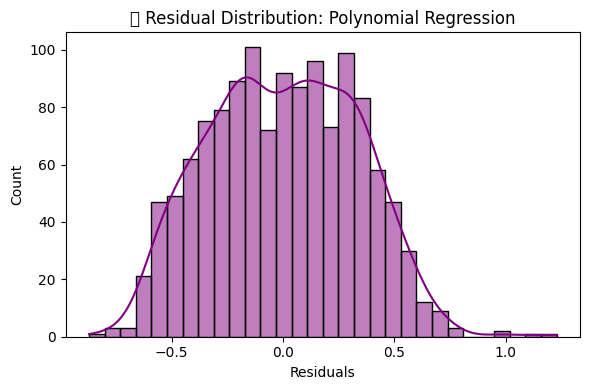

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure results from previous block are available: results_xgb, results_lr, results_poly
# And y_test, y_pred_xgb, y_pred_lr, y_pred_poly are also available

# --------------------------------------
# 1. Bar Chart for Evaluation Metrics
# --------------------------------------

metrics_df = pd.DataFrame({
    'Model': ['XGBoost', 'Linear Regression', 'Polynomial Regression'],
    'RMSE': [results_xgb['RMSE'], results_lr['RMSE'], results_poly['RMSE']],
    'MAE': [results_xgb['MAE'], results_lr['MAE'], results_poly['MAE']],
    'R2 Score': [results_xgb['R2'], results_lr['R2'], results_poly['R2']],
})

metrics_df_melted = metrics_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Score', hue='Model', data=metrics_df_melted)
plt.title('📊 Model Comparison Based on Evaluation Metrics')
plt.ylabel('Score')
plt.xlabel('Metric')
plt.legend(title='Model')
plt.tight_layout()
plt.show()

# --------------------------------------
# 2. Scatter Plots: Actual vs Predicted
# --------------------------------------

def plot_actual_vs_predicted(y_true, y_pred, model_name):
    plt.figure(figsize=(6, 5))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], '--r', label='Perfect Prediction')
    plt.xlabel('Actual Exam Scores')
    plt.ylabel('Predicted Exam Scores')
    plt.title(f'📈 Actual vs Predicted: {model_name}')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_actual_vs_predicted(y_test, y_pred_xgb, "XGBoost")
plot_actual_vs_predicted(y_test, y_pred_lr, "Linear Regression")
plot_actual_vs_predicted(y_test, y_pred_poly, "Polynomial Regression")

# --------------------------------------
# 3. Residual Plots
# --------------------------------------

def plot_residuals(y_true, y_pred, model_name):
    residuals = y_true - y_pred
    plt.figure(figsize=(6, 4))
    sns.histplot(residuals, bins=30, kde=True, color='purple')
    plt.title(f'🌀 Residual Distribution: {model_name}')
    plt.xlabel('Residuals')
    plt.tight_layout()
    plt.show()

plot_residuals(y_test, y_pred_xgb, "XGBoost")
plot_residuals(y_test, y_pred_lr, "Linear Regression")
plot_residuals(y_test, y_pred_poly, "Polynomial Regression")


In [24]:
# ============================================================================
# STEP 9: PREDICTION EXAMPLES FOR ALL 3 MODELS
# ============================================================================

print("\n" + "="*60)
print("PREDICTION EXAMPLES")
print("="*60)

# Define consistent realistic student profiles
example_data = {
    'Hours_Studied': [3, 6, 18],
    'Attendance': [70, 85, 95],
    'Previous_Scores': [60, 75, 95],
}

# Fill all remaining required features with median values
def build_example_df(required_features):
    example_df = pd.DataFrame(example_data)
    for feat in required_features:
        if feat not in example_df.columns:
            median_value = df_clean[feat].median()
            example_df[feat] = [median_value] * len(example_df) # Ensure the length matches the number of examples
    return example_df[required_features]

# Create data for each model
# Using the feature lists defined in the previous cell
example_lr = build_example_df(features_lr)
example_poly = build_example_df(features_poly)
example_xgb = build_example_df(features_xgb)

# Make predictions
lr_preds = lr.predict(example_lr) # Using the 'lr' model from cell vQLJwUyIZ0Zy
poly_preds = poly_lr.predict(poly.transform(example_poly)) # Using 'poly_lr' and 'poly' from cell vQLJwUyIZ0Zy
xgb_preds = xgb.predict(example_xgb) # Using the 'xgb' model from cell vQLJwUyIZ0Zy


# Display
print("\n🎓 Example Student Profiles (first 3 features shown):")
# Display only the originally provided example features for clarity
print(example_lr[['Hours_Studied', 'Attendance', 'Previous_Scores']])

print("\n📊 Predicted Exam Scores by Each Model:")
predictions_df = pd.DataFrame({
    'Student': ['Student A', 'Student B', 'Student C'],
    'Linear Regression': lr_preds.round(2),
    'Polynomial Regression': poly_preds.round(2),
    'XGBoost': xgb_preds.round(2),
})
print(predictions_df)


PREDICTION EXAMPLES

🎓 Example Student Profiles (first 3 features shown):
   Hours_Studied  Attendance  Previous_Scores
0              3          70               60
1              6          85               75
2             18          95               95

📊 Predicted Exam Scores by Each Model:
     Student  Linear Regression  Polynomial Regression    XGBoost
0  Student A              58.83                  58.63  59.580002
1  Student B              63.40                  63.24  63.570000
2  Student C              69.85                  69.78  69.800003


In [25]:
# ============================================================================
# STEP 9: PREDICTION EXAMPLES FOR ALL 3 MODELS (IMPROVED)
# ============================================================================

print("\n" + "="*60)
print("🎯 PREDICTION EXAMPLES (IMPROVED)")
print("="*60)

# Define consistent base features
example_data = {
    'Hours_Studied': [3, 6, 18],
    'Attendance': [70, 85, 95],
    'Previous_Scores': [60, 75, 95],

    # Additional known impactful features
    'Motivation_Level_encoded': [1, 3, 5],
    'Tutoring_Sessions_encoded': [0, 1, 2],
    'Internet_Access_encoded': [0, 1, 1],
    'Parental_Involvement_encoded': [1, 2, 4],
    'Access_to_Resources_encoded': [1, 3, 4],
    'Learning_Disabilities_encoded': [1, 0, 0]
}

# Function to build example DataFrame per model
def build_example_df(required_features):
    example_df = pd.DataFrame(example_data)
    for feat in required_features:
        if feat not in example_df.columns:
            median_value = df_clean[feat].median()
            example_df[feat] = [median_value] * len(example_df)
    return example_df[required_features]

# Create input sets
example_lr = build_example_df(features_lr)
example_poly = build_example_df(features_poly)
example_xgb = build_example_df(features_xgb)

# Make predictions
lr_preds = lr.predict(example_lr)
poly_preds = poly_lr.predict(poly.transform(example_poly))
xgb_preds = xgb.predict(example_xgb)

# Display
print("\n🎓 Example Student Profiles (first 5 features shown):")
print(example_lr[['Hours_Studied', 'Attendance', 'Previous_Scores', 'Motivation_Level_encoded', 'Tutoring_Sessions_encoded']])

print("\n📊 Predicted Exam Scores by Each Model:")
predictions_df = pd.DataFrame({
    'Student': ['Student A', 'Student B', 'Student C'],
    'Linear Regression': lr_preds.round(2),
    'Polynomial Regression': poly_preds.round(2),
    'XGBoost': xgb_preds.round(2),
})
print(predictions_df)


🎯 PREDICTION EXAMPLES (IMPROVED)

🎓 Example Student Profiles (first 5 features shown):
   Hours_Studied  Attendance  Previous_Scores  Motivation_Level_encoded  \
0              3          70               60                         1   
1              6          85               75                         3   
2             18          95               95                         5   

   Tutoring_Sessions_encoded  
0                          0  
1                          1  
2                          2  

📊 Predicted Exam Scores by Each Model:
     Student  Linear Regression  Polynomial Regression    XGBoost
0  Student A              57.24                  53.58  55.799999
1  Student B              62.86                  69.32  63.570000
2  Student C              68.32                 102.65  70.199997
